In [2]:
import bilby
import gwpopulation as gwpop        # used for population models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dill

from bilby.core.prior import PriorDict, Uniform
from gwpopulation.hyperpe import HyperparameterLikelihood



%matplotlib inline

### Data Acquisition & Cleaning

In [3]:
posteriors = pd.read_pickle("gwtc-3-samples.pkl")
del posteriors[15]      
del posteriors[38]

In [4]:
posteriors[0]

mass_1  mass_ratio       a_1       a_2  cos_tilt_1  cos_tilt_2  \
50071   33.136361    0.947207  0.404503  0.497368    0.969833   -0.830245   
81420   35.521402    0.764971  0.292579  0.049531   -0.762859   -0.239064   
3832    36.359435    0.840993  0.626148  0.749870    0.012735    0.220519   
114471  33.348556    0.972678  0.062689  0.117746   -0.253675    0.549356   
46641   34.242166    0.825938  0.476832  0.154817   -0.441843   -0.915523   
...           ...         ...       ...       ...         ...         ...   
75074   33.474866    0.973315  0.695592  0.090727    0.196613    0.497039   
72399   35.257598    0.867935  0.291883  0.069884   -0.515272    0.329685   
58264   33.276222    0.943216  0.111093  0.032642   -0.023936   -0.880299   
48402   33.784014    0.849338  0.569377  0.615687   -0.064213   -0.598698   
127537  36.879618    0.836356  0.826267  0.042920    0.115525   -0.835264   

        redshift     prior  
50071   0.134033  0.454601  
81420   0.095303  0.247454  
3832    0.111405  0.345586  
114471  0.109960  0.308843  
46641   0.075218  0.148797  
...          ...       ...  
75074   0.131470  0.442006  
72399   0.063814  0.110345  
58264   0.088038  0.197934  
48402   0.066827  0.115946  
127537  0.086457  0.211599  

[6913 rows x 8 columns]

### Injections

In [5]:
with open("gwtc-3-injections.pkl", "rb") as ff:
    injections = dill.load(ff)

In [6]:
injections

{'mass_1': array([17.39769745, 27.59049225, 34.87878799, ..., 51.90734739,
        78.03708648, 35.8333281 ]),
 'mass_ratio': array([0.89051247, 0.88072689, 0.98982847, ..., 0.87312348, 0.80260149,
        0.90983453]),
 'a_1': array([0.66609327, 0.77165711, 0.41970315, ..., 0.00470902, 0.00137732,
        0.48066029]),
 'a_2': array([0.84130038, 0.26786459, 0.2287109 , ..., 0.44948848, 0.5727499 ,
        0.93711565]),
 'cos_tilt_1': array([-0.37940198, -0.17241716,  0.21326955, ..., -0.56725815,
         0.64015502, -0.16667346]),
 'cos_tilt_2': array([ 0.38100872,  0.5378555 , -0.14621086, ...,  0.80703564,
         0.59299658, -0.1641033 ]),
 'redshift': array([0.19250949, 0.3339659 , 0.98206556, ..., 0.12487546, 0.52983057,
        0.33013271]),
 'prior': array([1.09751025e-04, 9.41494849e-05, 2.51845033e-04, ...,
        2.40199909e-06, 5.07814672e-05, 8.27588353e-05]),
 'total_generated': 73280198,
 'analysis_time': 2.000455579638502}

### `TRUNCATED` (Power Law) Mass Model

In [7]:
def power_law_mass_distribution(dataset, alpha, m_min, m_max):
    """
    Power-law mass distribution applied to an array of samples.

    Parameters:
        dataset (dict): Dictionary of posterior samples.
        alpha (float): Spectral index.
        m_min (float): Minimum mass cutoff.
        m_max (float): Maximum mass cutoff.

    Returns:
        np.ndarray: Probability densities for each sample.
    """
    mass_1 = dataset['mass_1']
    valid_range = (mass_1 >= m_min) & (mass_1 <= m_max)
    normalization = (1 - alpha) / (m_max**(1 - alpha) - m_min**(1 - alpha))
    epsilon = 1e-10  # Small value to avoid log(0)
    probabilities = np.where(valid_range, normalization * mass_1**(-alpha) + epsilon, epsilon)
    return probabilities

In [8]:
power_law_vt = gwpop.vt.ResamplingVT(model=power_law_mass_distribution, data=injections, n_events=len(posteriors))

In [9]:
def gwpop_power_law_mass_distribution(dataset, alpha, m_min, m_max):
    mass_1 = dataset['mass_1']
    return gwpop.models.mass.power_law_mass(mass_1, alpha, m_min, m_max)

In [10]:
gwpop_power_law_vt = gwpop.vt.ResamplingVT(model=gwpop_power_law_mass_distribution, data=injections, n_events=len(posteriors))

In [11]:
power_priors = bilby.core.prior.PriorDict()

power_priors['alpha'] = Uniform(-4, 12, 'alpha', latex_label='$\\alpha$')
power_priors['m_min']=  Uniform(5, 10, 'm_min', latex_label='$m_{min}$')
power_priors['m_max']=  Uniform(30, 100, 'm_max', latex_label='$m_{max}$')

power_priors

{'alpha': Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None),
 'm_min': Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None),
 'm_max': Uniform(minimum=30, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)}

### `POWER LAW + PEAK` Mass Model

In [12]:

def smoothingf(dataset, m_min, del_m):
    """
    Smoothing function for mass distribution.

    Parameters:
        dataset (dict): Dictionary of posterior samples.
        m_min (float): Minimum mass cutoff.
        del_m (float): Smoothing range.

    Returns:
        np.ndarray: Smoothing factors for each sample.
    """
    mass_1 = dataset['mass_1']
    result = np.ones_like(mass_1)
    
    # Ensure no division by zero
    safe_mass = np.clip(mass_1 - m_min, 1e-6, None)
    safe_mass_del_m = np.clip(mass_1 - m_min - del_m, 1e-6, None)
    
    lower_range = (mass_1 >= m_min) & (mass_1 < m_min + del_m)
    upper_range = mass_1 >= m_min + del_m
    
    # Clip the exponentials to prevent overflow
    exponent = np.clip(
        (del_m / safe_mass[lower_range]) + (del_m / safe_mass_del_m[lower_range]),
        -700, 700  # Limits chosen based on np.exp numerical limits
    )
    
    result[lower_range] = 1 / (np.exp(exponent) + 1)
    result[upper_range] = 1
    
    # Replace invalid entries
    result[~np.isfinite(result)] = 0

    return result



def power_plus_peak_mass_distribution(dataset, alpha, m_min, m_max, lam, mpp, sigpp, del_m):
    """
    Combined power-law and Gaussian mass distribution with smoothing.

    Parameters:
        dataset (dict): Dictionary of posterior samples.
        alpha (float): Spectral index.
        m_min (float): Minimum mass cutoff.
        m_max (float): Maximum mass cutoff.
        mpp (float): Mean of Gaussian peak.
        sigma (float): Standard deviation of Gaussian peak.
        f_peak (float): Mixing fraction between power-law and Gaussian peak.
        del_m (float): Smoothing range.

    Returns:
        np.ndarray: Combined probability density for each sample.
    """
    mass_1 = dataset['mass_1']
    valid_range = (mass_1 >= m_min) & (mass_1 <= m_max)

    power_law = np.where(valid_range, mass_1**(-alpha), 0)
    gaussian = np.exp(-0.5 * ((mass_1 - mpp) / sigpp)**2) / (sigpp * np.sqrt(2 * np.pi))
    
    smooth = smoothingf(dataset, m_min, del_m)
    p_combined = ((1 - lam) * power_law + lam * gaussian) * smooth
    epsilon = 1e-10

    p_out = np.where(valid_range, p_combined + epsilon, epsilon)


    return p_out



In [13]:
power_plus_peak_mass_distribution_vt = gwpop.vt.ResamplingVT(model=power_plus_peak_mass_distribution, data=injections, n_events=len(posteriors))

In [14]:
def gwpop_power_plus_peak_mass_distribution(dataset, alpha, m_min, m_max, lam, mpp, sigpp):
    mass_1 = dataset['mass_1']
    p_combined = gwpop.models.mass.two_component_single(
        mass_1, alpha, m_min, m_max, lam, mpp, sigpp,
        gaussian_mass_maximum=100
    )
    
    epsilon = 1e-10
    p_out = p_combined + epsilon

    return p_out

In [15]:
gwpop_power_plus_peak_mass_distribution_vt = gwpop.vt.ResamplingVT(model=gwpop_power_plus_peak_mass_distribution, data=injections, n_events=len(posteriors))

In [16]:
power_plus_peak_priors = bilby.core.prior.PriorDict()

power_plus_peak_priors['alpha'] =  Uniform(-4, 12, 'alpha', latex_label='$\\alpha$')
power_plus_peak_priors['m_min']=  Uniform(5, 10, 'm_min', latex_label='$m_{min}$')
power_plus_peak_priors['m_max']=  Uniform(50, 100, 'm_max', latex_label='$m_{max}$')
power_plus_peak_priors['mpp']=     Uniform(20, 50, 'mpp', latex_label='$\\mu_p$')
power_plus_peak_priors['sigpp']=  Uniform(1, 10, 'sigpp', latex_label='$\\sigma_p$')
power_plus_peak_priors['lam']= Uniform(0, 1, 'lam', latex_label='$\\lambda_{peak}$')
power_plus_peak_priors['del_m'] = Uniform(0, 10, 'del_m', latex_label='$\\delta_m$')

power_plus_peak_priors


{'alpha': Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None),
 'm_min': Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None),
 'm_max': Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None),
 'mpp': Uniform(minimum=20, maximum=50, name='mpp', latex_label='$\\mu_p$', unit=None, boundary=None),
 'sigpp': Uniform(minimum=1, maximum=10, name='sigpp', latex_label='$\\sigma_p$', unit=None, boundary=None),
 'lam': Uniform(minimum=0, maximum=1, name='lam', latex_label='$\\lambda_{peak}$', unit=None, boundary=None),
 'del_m': Uniform(minimum=0, maximum=10, name='del_m', latex_label='$\\delta_m$', unit=None, boundary=None)}

### `BROKEN POWER-LAW` Mass Model

In [17]:
def broken_power_law_mass_distribution(dataset, alpha_1, alpha_2, m_min, m_max, break_fraction):
    """
    Hand-written (piecewise) broken power law.
    We break at m_break = m_min + break_fraction*(m_max - m_min).

    p(m) = C1 * m^(-alpha1),   for m_min <= m < m_break
           C2 * m^(-alpha2),   for m_break <= m <= m_max

    with a normalization that ensures the integral from m_min to m_max is 1.
    """
    mass_1 = dataset['mass_1']
    
    valid_range = (mass_1 >= m_min) & (mass_1 <= m_max)

    m_break = m_min + break_fraction * (m_max - m_min)

    # Helper for the integral of m^(-alpha)
    def integrate_power(m_low, m_high, alpha):
        if np.isclose(alpha, 1.0):
            return np.log(m_high / m_low)
        else:
            return (m_high**(1 - alpha) - m_low**(1 - alpha)) / (1 - alpha)

    # Integral of first piece
    I1 = integrate_power(m_min, m_break, alpha_1)
    # Integral of second piece
    I2 = integrate_power(m_break, m_max, alpha_2)

    # We also need a factor for continuity at the break
    # but a simpler approach is the standard "broken power law" normalization:
    #   total integral = I1 + (m_break^(-alpha2 + alpha1)) * I2
    # then factor = 1 / total_integral
    # For the second piece, we multiply by m_break^( -alpha2 + alpha1 ) so that
    # it's continuous at the break if you want that. 
    # Or we can do a strict piecewise. Let's do the standard approach:
    
    factor_2 = m_break**(-alpha_2 + alpha_1)
    total_integral = I1 + factor_2 * I2
    C = 1.0 / total_integral

    # Evaluate piecewise:
    p1 = C * mass_1**(-alpha_1)
    p2 = C * factor_2 * mass_1**(-alpha_2)

    # Combine
    p_combined = np.zeros_like(mass_1)
    p_combined[(mass_1 >= m_min) & (mass_1 < m_break)] = p1[(mass_1 >= m_min) & (mass_1 < m_break)]
    p_combined[(mass_1 >= m_break) & (mass_1 <= m_max)] = p2[(mass_1 >= m_break) & (mass_1 <= m_max)]

    epsilon = 1e-10
    p_out = np.where(valid_range, p_combined + epsilon, epsilon)
    return p_out

In [18]:
broken_power_law_mass_distribution_vt = gwpop.vt.ResamplingVT(model=broken_power_law_mass_distribution, data=injections, n_events=len(posteriors))

In [19]:
def gwpop_broken_power_law_mass_distribution(dataset, alpha_1, alpha_2, m_min, m_max, break_fraction):
    """
    Wrapper around gwpop double_power_law_primary_mass
    to evaluate a broken power law from gwpopulation,
    plus an epsilon offset.
    """
    mass_1 = dataset['mass_1']
    p = gwpop.models.mass.double_power_law_primary_mass(
        mass=mass_1,
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        mmin=m_min,
        mmax=m_max,
        break_fraction=break_fraction
    )
    epsilon = 1e-10
    p_out = p + epsilon
    return p_out

In [20]:
gwpop_broken_power_law_mass_distribution_vt = gwpop.vt.ResamplingVT(model=gwpop_broken_power_law_mass_distribution, data=injections, n_events=len(posteriors))

In [21]:
broken_power_law_priors = bilby.core.prior.PriorDict()

broken_power_law_priors['alpha_1'] =  Uniform(-4, 12, 'alpha_1', latex_label='$\\alpha_1$')
broken_power_law_priors['alpha_2'] =  Uniform(-4, 12, 'alpha_2', latex_label='$\\alpha_2$')
broken_power_law_priors['m_min']=  Uniform(5, 10, 'm_min', latex_label='$m_{min}$')
broken_power_law_priors['m_max']=  Uniform(50, 100, 'm_max', latex_label='$m_{max}$')
broken_power_law_priors['break_fraction'] = Uniform(0,1, 'break_fraction', latex_label='$b (break fraction)$')

broken_power_law_priors

{'alpha_1': Uniform(minimum=-4, maximum=12, name='alpha_1', latex_label='$\\alpha_1$', unit=None, boundary=None),
 'alpha_2': Uniform(minimum=-4, maximum=12, name='alpha_2', latex_label='$\\alpha_2$', unit=None, boundary=None),
 'm_min': Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None),
 'm_max': Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None),
 'break_fraction': Uniform(minimum=0, maximum=1, name='break_fraction', latex_label='$b (break fraction)$', unit=None, boundary=None)}

### `MULTIPEAK` Mass Model

In [22]:
def multi_peak_mass_distribution(
    dataset,
    alpha,
    m_min,
    m_max,
    lam,
    lam_1,
    mpp_1,
    sigpp_1,
    mpp_2,
    sigpp_2
):
    """
    Amateur multi-peak (two Gaussians) + power law:
      p(m) = (1 - lam)*PL(m) + lam* [ lam_1*Gauss1(m) + (1-lam_1)*Gauss2(m) ].

    We do a naive normalization. Add an epsilon to avoid log(0).
    """
    mass_1 = dataset['mass_1']
    valid_range = (mass_1 >= m_min) & (mass_1 <= m_max)

    # Basic power law portion, roughly normalized
    if np.isclose(alpha, 1.0):
        pl_norm = 1.0 / np.log(m_max/m_min)
    else:
        pl_norm = (1.0 - alpha) / (m_max**(1.0 - alpha) - m_min**(1.0 - alpha))
    pl_part = np.where(valid_range, pl_norm * mass_1**(-alpha), 0.0)

    # Gaussian 1
    # standard Gaussian in [m_min, m_max].
    gauss1 = np.exp(-0.5 * ((mass_1 - mpp_1)/sigpp_1)**2) / (sigpp_1 * np.sqrt(2*np.pi))
    # Zero outside [m_min, m_max]
    gauss1 = np.where(valid_range, gauss1, 0.0)
    # Similarly for Gaussian 2
    gauss2 = np.exp(-0.5 * ((mass_1 - mpp_2)/sigpp_2)**2) / (sigpp_2 * np.sqrt(2*np.pi))
    gauss2 = np.where(valid_range, gauss2, 0.0)

    # Combine
    p_combined = (1 - lam)*pl_part + lam*(lam_1*gauss1 + (1 - lam_1)*gauss2)

    epsilon = 1e-10
    p_out = p_combined + epsilon
    return p_out

In [23]:
multi_peak_mass_distribution_vt = gwpop.vt.ResamplingVT(model=multi_peak_mass_distribution, data=injections, n_events=len(posteriors))

In [24]:
def gwpop_multi_peak_mass_distribution(
    dataset,
    alpha,
    m_min,
    m_max,
    lam,
    lam_1,
    mpp_1,
    sigpp_1,
    mpp_2,
    sigpp_2
):
    """
    Wrapper around gwpop three_component_single
    for a 2-Gaussian + power law model.
    """
    mass_1 = dataset['mass_1']
    p = gwpop.models.mass.three_component_single(
        mass=mass_1,
        alpha=alpha,
        mmin=m_min,
        mmax=m_max,
        lam=lam,          # total fraction in Gaussians
        lam_1=lam_1,      # fraction for first Gaussian out of lam
        mpp_1=mpp_1,
        sigpp_1=sigpp_1,
        mpp_2=mpp_2,
        sigpp_2=sigpp_2,
        gaussian_mass_maximum=100
    )
    epsilon = 1e-10
    p_out = p + epsilon
    return p_out

In [25]:
gwpop_multi_peak_mass_distribution_vt = gwpop.vt.ResamplingVT(model=gwpop_multi_peak_mass_distribution, data=injections, n_events=len(posteriors))

In [26]:
multi_peak_priors = bilby.core.prior.PriorDict()

multi_peak_priors['alpha'] =  Uniform(-4, 12, 'alpha', latex_label='$\\alpha$')
multi_peak_priors['m_min']=  Uniform(5, 10, 'm_min', latex_label='$m_{min}$')
multi_peak_priors['m_max']=  Uniform(50, 100, 'm_max', latex_label='$m_{max}$')
multi_peak_priors['mpp_1']=     Uniform(20, 50, 'mpp_1', latex_label='$\\mu_{m,1}$')
multi_peak_priors['mpp_2']=     Uniform(20, 50, 'mpp_2', latex_label='$\\mu_{m,2}p$')
multi_peak_priors['sigpp_1']=  Uniform(1, 10, 'sigpp_1', latex_label='$\\sigma_{m,1}$')
multi_peak_priors['sigpp_2']=  Uniform(1, 10, 'sigpp_2', latex_label='$\\sigma_{m,2}$')
multi_peak_priors['lam']= Uniform(0, 1, 'lam', latex_label='$\\lambda$')
multi_peak_priors['lam_1']= Uniform(0, 1, 'lam_1', latex_label='$\\lambda_{low}$')

multi_peak_priors


{'alpha': Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None),
 'm_min': Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None),
 'm_max': Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None),
 'mpp_1': Uniform(minimum=20, maximum=50, name='mpp_1', latex_label='$\\mu_{m,1}$', unit=None, boundary=None),
 'mpp_2': Uniform(minimum=20, maximum=50, name='mpp_2', latex_label='$\\mu_{m,2}p$', unit=None, boundary=None),
 'sigpp_1': Uniform(minimum=1, maximum=10, name='sigpp_1', latex_label='$\\sigma_{m,1}$', unit=None, boundary=None),
 'sigpp_2': Uniform(minimum=1, maximum=10, name='sigpp_2', latex_label='$\\sigma_{m,2}$', unit=None, boundary=None),
 'lam': Uniform(minimum=0, maximum=1, name='lam', latex_label='$\\lambda$', unit=None, boundary=None),
 'lam_1': Uniform(minimum=0, maximum=1, name='lam_1', latex_label='$\\lambda_{low}$', unit=None, boundary=None)}

### Running the analysis

In [27]:
# Hand written power law mass distribution

power_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=power_law_mass_distribution,
    selection_function=power_law_vt                       

)

In [28]:
# GWPopulation power law mass distribution

gwpop_power_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=gwpop_power_law_mass_distribution,
    selection_function=gwpop_power_law_vt
)

In [29]:
# Hand written power + peak mass distribution

power_plus_peak_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=power_plus_peak_mass_distribution,
    selection_function=power_plus_peak_mass_distribution_vt                       

)

In [30]:
# GWPopulation power + peak mass distribution

gwpop_power_plus_peak_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=gwpop_power_plus_peak_mass_distribution,
    selection_function=gwpop_power_plus_peak_mass_distribution_vt                       

)

In [31]:
# Hand written broken power law mass distribution

broken_power_law_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=broken_power_law_mass_distribution,
    selection_function=broken_power_law_mass_distribution_vt                       

)

In [32]:
# GWPopulation broken power law mass distribution

gwpop_broken_power_law_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=gwpop_broken_power_law_mass_distribution,
    selection_function=gwpop_broken_power_law_mass_distribution_vt                       
)

In [33]:
# Hand written multi-peak mass distribution

multi_peak_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=multi_peak_mass_distribution,
    selection_function=multi_peak_mass_distribution_vt                       

)

In [34]:
# GWPopulation multi-peak mass distribution

gwpop_multi_peak_likelihood = HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=gwpop_multi_peak_mass_distribution,
    selection_function=gwpop_multi_peak_mass_distribution_vt                       

)

In [35]:
power_law_result = bilby.run_sampler(
    likelihood=     power_likelihood,
    priors=         power_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'power law'
)

02:14 bilby INFO    : Running for label 'power law', output will be saved to 'outdir'
02:14 bilby INFO    : Analysis priors:
02:14 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
02:14 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:14 bilby INFO    : m_max=Uniform(minimum=30, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:14 bilby INFO    : Analysis likelihood class: <class 'gwpopulation.hyperpe.HyperparameterLikelihood'>
02:14 bilby INFO    : Analysis likelihood noise evidence: nan
02:14 bilby INFO    : Single likelihood evaluation took 8.612e-03 s
02:14 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 100, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool

10709it [00:00, ?it/s]

02:14 bilby INFO    : Written checkpoint file outdir/power law_resume.pickle
02:14 bilby INFO    : Rejection sampling nested samples to obtain 3304 posterior samples
02:14 bilby INFO    : Sampling time: 0:26:14.989714


02:14 bilby INFO    : Summary of results:
nsamples: 3304
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.070
ln_bayes_factor: -334.443 +/-  0.070



In [36]:
gwpop_power_law_result = bilby.run_sampler(
    likelihood=     gwpop_power_likelihood,
    priors=         power_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'gwpop power law',
)

02:14 bilby INFO    : Running for label 'gwpop power law', output will be saved to 'outdir'
02:14 bilby INFO    : Analysis priors:
02:14 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
02:14 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:14 bilby INFO    : m_max=Uniform(minimum=30, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:14 bilby INFO    : Analysis likelihood class: <class 'gwpopulation.hyperpe.HyperparameterLikelihood'>
02:14 bilby INFO    : Analysis likelihood noise evidence: nan
/home/egeki/anaconda3/lib/python3.12/site-packages/gwpopulation/hyperpe.py:209: RuntimeWarning: invalid value encountered in divide
  variance = (square_expectation - expectation**2) / (
/home/egeki/anaconda3/lib/python3.12/site-packages/gwpopulation/hyperpe.py:212: RuntimeWarning: divide by zero encountered in log
  return x

524it [00:00, ?it/s]

02:14 bilby INFO    : Written checkpoint file outdir/gwpop power law_resume.pickle
02:14 bilby INFO    : Rejection sampling nested samples to obtain 112 posterior samples
02:14 bilby INFO    : Sampling time: 4:24:30.065987


02:14 bilby INFO    : Summary of results:
nsamples: 112
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.405
ln_bayes_factor: -267.350 +/-  0.405



In [37]:
power_plus_peak_result = bilby.run_sampler(
    likelihood=     power_plus_peak_likelihood,
    priors=         power_plus_peak_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'power plus peak'
)

02:14 bilby INFO    : Running for label 'power plus peak', output will be saved to 'outdir'
02:14 bilby INFO    : Analysis priors:
02:14 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
02:14 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:14 bilby INFO    : m_max=Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:14 bilby INFO    : mpp=Uniform(minimum=20, maximum=50, name='mpp', latex_label='$\\mu_p$', unit=None, boundary=None)
02:14 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name='sigpp', latex_label='$\\sigma_p$', unit=None, boundary=None)
02:14 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name='lam', latex_label='$\\lambda_{peak}$', unit=None, boundary=None)
02:14 bilby INFO    : del_m=Uniform(minimum=0, maximum=10, name='del_m', latex_label='$\\delta_m$', unit=None, boundary=N

878it [00:00, ?it/s]

02:15 bilby INFO    : Written checkpoint file outdir/power plus peak_resume.pickle
02:15 bilby INFO    : Rejection sampling nested samples to obtain 91 posterior samples
02:15 bilby INFO    : Sampling time: 0:33:24.919286


02:15 bilby INFO    : Summary of results:
nsamples: 91
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.527
ln_bayes_factor: -261.503 +/-  0.527



In [38]:
gwpop_power_plus_peak_result = bilby.run_sampler(
    likelihood=     gwpop_power_plus_peak_likelihood,
    priors=         power_plus_peak_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'gwpop power plus peak'
)

02:15 bilby INFO    : Running for label 'gwpop power plus peak', output will be saved to 'outdir'
02:15 bilby INFO    : Analysis priors:
02:15 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
02:15 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:15 bilby INFO    : m_max=Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:15 bilby INFO    : mpp=Uniform(minimum=20, maximum=50, name='mpp', latex_label='$\\mu_p$', unit=None, boundary=None)
02:15 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name='sigpp', latex_label='$\\sigma_p$', unit=None, boundary=None)
02:15 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name='lam', latex_label='$\\lambda_{peak}$', unit=None, boundary=None)
02:15 bilby INFO    : del_m=Uniform(minimum=0, maximum=10, name='del_m', latex_label='$\\delta_m$', unit=None, boun

831it [00:00, ?it/s]

02:15 bilby INFO    : Written checkpoint file outdir/gwpop power plus peak_resume.pickle
02:15 bilby INFO    : Rejection sampling nested samples to obtain 96 posterior samples
02:15 bilby INFO    : Sampling time: 0:22:57.297226


02:15 bilby INFO    : Summary of results:
nsamples: 96
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.508
ln_bayes_factor: -260.939 +/-  0.508



In [39]:
broken_power_law_result = bilby.run_sampler(
    likelihood=     broken_power_law_likelihood,
    priors=         broken_power_law_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'broken power law',
)

02:16 bilby INFO    : Running for label 'broken power law', output will be saved to 'outdir'
02:16 bilby INFO    : Analysis priors:
02:16 bilby INFO    : alpha_1=Uniform(minimum=-4, maximum=12, name='alpha_1', latex_label='$\\alpha_1$', unit=None, boundary=None)
02:16 bilby INFO    : alpha_2=Uniform(minimum=-4, maximum=12, name='alpha_2', latex_label='$\\alpha_2$', unit=None, boundary=None)
02:16 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:16 bilby INFO    : m_max=Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:16 bilby INFO    : break_fraction=Uniform(minimum=0, maximum=1, name='break_fraction', latex_label='$b (break fraction)$', unit=None, boundary=None)
02:16 bilby INFO    : Analysis likelihood class: <class 'gwpopulation.hyperpe.HyperparameterLikelihood'>
02:16 bilby INFO    : Analysis likelihood noise evidence: nan
02:16 bilby INFO    : Single likeliho

313it [00:00, ?it/s]

02:17 bilby INFO    : Written checkpoint file outdir/broken power law_resume.pickle
02:29 bilby INFO    : Written checkpoint file outdir/broken power law_resume.pickle
02:42 bilby INFO    : Written checkpoint file outdir/broken power law_resume.pickle
02:53 bilby INFO    : Written checkpoint file outdir/broken power law_resume.pickle
02:57 bilby INFO    : Written checkpoint file outdir/broken power law_resume.pickle
02:57 bilby INFO    : Rejection sampling nested samples to obtain 107 posterior samples
02:57 bilby INFO    : Sampling time: 3:15:48.728317


02:57 bilby INFO    : Summary of results:
nsamples: 107
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.598
ln_bayes_factor: -265.577 +/-  0.598



In [40]:
gwpop_broken_power_law_result = bilby.run_sampler(
    likelihood=     gwpop_broken_power_law_likelihood,
    priors=         broken_power_law_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'gwpop broken power law'
)

02:57 bilby INFO    : Running for label 'gwpop broken power law', output will be saved to 'outdir'
02:57 bilby INFO    : Analysis priors:
02:57 bilby INFO    : alpha_1=Uniform(minimum=-4, maximum=12, name='alpha_1', latex_label='$\\alpha_1$', unit=None, boundary=None)
02:57 bilby INFO    : alpha_2=Uniform(minimum=-4, maximum=12, name='alpha_2', latex_label='$\\alpha_2$', unit=None, boundary=None)
02:57 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:57 bilby INFO    : m_max=Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:57 bilby INFO    : break_fraction=Uniform(minimum=0, maximum=1, name='break_fraction', latex_label='$b (break fraction)$', unit=None, boundary=None)
02:57 bilby INFO    : Analysis likelihood class: <class 'gwpopulation.hyperpe.HyperparameterLikelihood'>
02:57 bilby INFO    : Analysis likelihood noise evidence: nan
02:57 bilby INFO    : Single li

751it [00:00, ?it/s]

02:58 bilby INFO    : Written checkpoint file outdir/gwpop broken power law_resume.pickle
02:58 bilby INFO    : Rejection sampling nested samples to obtain 99 posterior samples
02:58 bilby INFO    : Sampling time: 0:06:46.759497


02:58 bilby INFO    : Summary of results:
nsamples: 99
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.472
ln_bayes_factor: -265.333 +/-  0.472



In [41]:
multi_peak_result = bilby.run_sampler(
    likelihood=     multi_peak_likelihood,
    priors =        multi_peak_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'multi peak'
)

02:58 bilby INFO    : Running for label 'multi peak', output will be saved to 'outdir'
02:58 bilby INFO    : Analysis priors:
02:58 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
02:58 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:58 bilby INFO    : m_max=Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:58 bilby INFO    : mpp_1=Uniform(minimum=20, maximum=50, name='mpp_1', latex_label='$\\mu_{m,1}$', unit=None, boundary=None)
02:58 bilby INFO    : mpp_2=Uniform(minimum=20, maximum=50, name='mpp_2', latex_label='$\\mu_{m,2}p$', unit=None, boundary=None)
02:58 bilby INFO    : sigpp_1=Uniform(minimum=1, maximum=10, name='sigpp_1', latex_label='$\\sigma_{m,1}$', unit=None, boundary=None)
02:58 bilby INFO    : sigpp_2=Uniform(minimum=1, maximum=10, name='sigpp_2', latex_label='$\\sigma_{m,2}$', 

892it [00:00, ?it/s]

02:58 bilby INFO    : Written checkpoint file outdir/multi peak_resume.pickle
02:58 bilby INFO    : Rejection sampling nested samples to obtain 90 posterior samples
02:58 bilby INFO    : Sampling time: 0:28:37.091186


02:58 bilby INFO    : Summary of results:
nsamples: 90
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.515
ln_bayes_factor: -261.131 +/-  0.515



In [42]:
gwpop_multi_peak_result = bilby.run_sampler(
    likelihood=     gwpop_multi_peak_likelihood,
    priors=         multi_peak_priors,
    sampler=        'dynesty',
    nlive=          100,
    dlogz=          1,
    label=          'gwpop multi peak'
)

02:58 bilby INFO    : Running for label 'gwpop multi peak', output will be saved to 'outdir'
02:58 bilby INFO    : Analysis priors:
02:58 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
02:58 bilby INFO    : m_min=Uniform(minimum=5, maximum=10, name='m_min', latex_label='$m_{min}$', unit=None, boundary=None)
02:58 bilby INFO    : m_max=Uniform(minimum=50, maximum=100, name='m_max', latex_label='$m_{max}$', unit=None, boundary=None)
02:58 bilby INFO    : mpp_1=Uniform(minimum=20, maximum=50, name='mpp_1', latex_label='$\\mu_{m,1}$', unit=None, boundary=None)
02:58 bilby INFO    : mpp_2=Uniform(minimum=20, maximum=50, name='mpp_2', latex_label='$\\mu_{m,2}p$', unit=None, boundary=None)
02:58 bilby INFO    : sigpp_1=Uniform(minimum=1, maximum=10, name='sigpp_1', latex_label='$\\sigma_{m,1}$', unit=None, boundary=None)
02:58 bilby INFO    : sigpp_2=Uniform(minimum=1, maximum=10, name='sigpp_2', latex_label='$\\sigma_{m,

880it [00:00, ?it/s]

02:58 bilby INFO    : Written checkpoint file outdir/gwpop multi peak_resume.pickle
02:58 bilby INFO    : Rejection sampling nested samples to obtain 93 posterior samples
02:58 bilby INFO    : Sampling time: 1:20:56.025947


02:58 bilby INFO    : Summary of results:
nsamples: 93
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.538
ln_bayes_factor: -261.307 +/-  0.538



### Results

In [43]:
power_law_result.posterior

alpha     m_min      m_max  log_likelihood  log_prior
0     1.707267  9.699476  98.912236     -339.580518  -8.630522
1     0.829006  6.788512  88.347788     -337.178350  -8.630522
2     1.469784  8.980377  88.635715     -336.993686  -8.630522
3     0.484573  6.477960  64.962156     -336.590450  -8.630522
4     0.866791  6.959753  86.558550     -336.535775  -8.630522
...        ...       ...        ...             ...        ...
3299  0.520468  9.156912  70.903157     -328.398249  -8.630522
3300  0.604116  9.380275  72.399908     -328.398205  -8.630522
3301  0.597809  9.320913  70.708104     -328.388420  -8.630522
3302  0.546286  9.220598  70.778723     -328.364032  -8.630522
3303  0.544981  9.136820  70.740175     -328.354524  -8.630522

[3304 rows x 5 columns]

In [44]:
gwpop_power_law_result.posterior

alpha     m_min      m_max  log_likelihood  log_prior
0    1.275291  9.150102  88.998136     -269.530208  -8.630522
1    1.801187  7.983191  94.670872     -269.525985  -8.630522
2    2.106278  9.224509  71.907847     -268.712905  -8.630522
3    0.865268  9.858847  73.599008     -267.136648  -8.630522
4    1.785969  9.624167  86.059400     -266.533994  -8.630522
..        ...       ...        ...             ...        ...
107  1.345201  8.767137  70.592111     -262.367509  -8.630522
108  1.491402  8.949724  73.056555     -262.306463  -8.630522
109  1.439538  8.832471  72.855189     -262.302649  -8.630522
110  1.451055  8.838854  73.489607     -262.242055  -8.630522
111  1.391794  8.958633  73.528085     -262.203873  -8.630522

[112 rows x 5 columns]

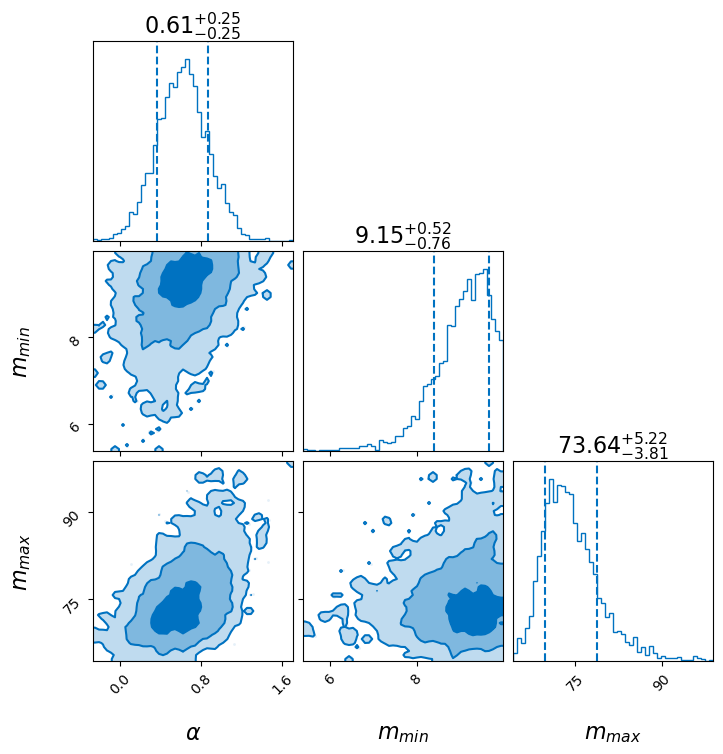

In [45]:
power_law_result.plot_corner(savefig=False)

In [46]:
alpha = power_law_result.posterior['alpha']

alpha_low = np.quantile(alpha, 0.05)
alpha_up = np.quantile(alpha, 0.95)
alpha_mu = np.quantile(alpha, 0.5)
print("alpha = {} with a 90% C.I = {} -> {}".format(alpha_mu, alpha_low, alpha_up))
print("GWTC-1 Result: alpha = 0.4 (-1.9, +1.4)")

alpha = 0.61423702809747 with a 90% C.I = 0.19220829081060065 -> 1.0294859932310323
GWTC-1 Result: alpha = 0.4 (-1.9, +1.4)


In [47]:
mmax = power_law_result.posterior['m_max']
mmax_low = np.quantile(mmax, 0.05)
mmax_up = np.quantile(mmax, 0.95)
mmax_mu = np.quantile(mmax, 0.5)
print("m_max = {} with a 90% C.I = {} -> {}".format(mmax_mu, mmax_low, mmax_up))
print("GWTC-3 Result: m_max = 78.5 (-9.4, +14.1)")

m_max = 73.63737874463285 with a 90% C.I = 67.86175433541915 -> 83.92002214502546
GWTC-3 Result: m_max = 78.5 (-9.4, +14.1)


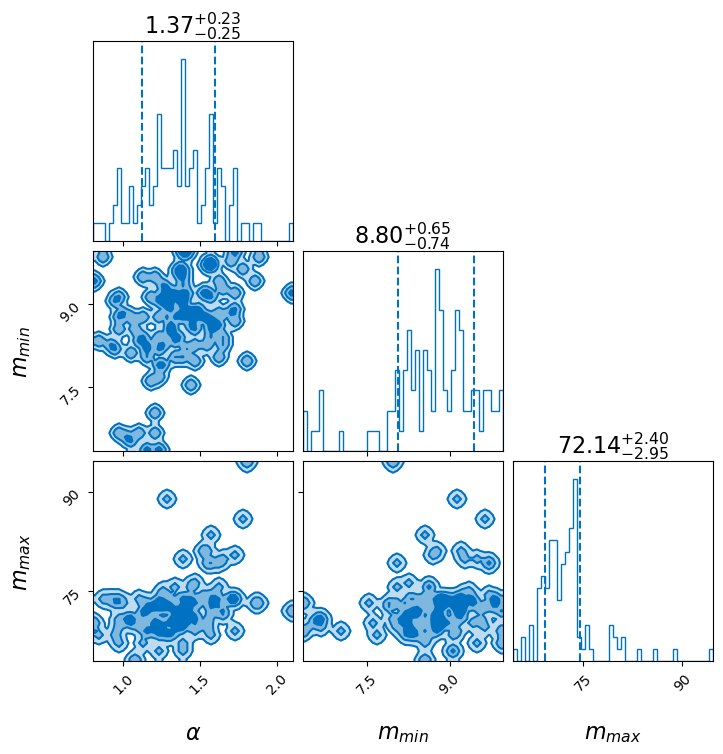

In [48]:
gwpop_power_law_result.plot_corner(savefig=False)

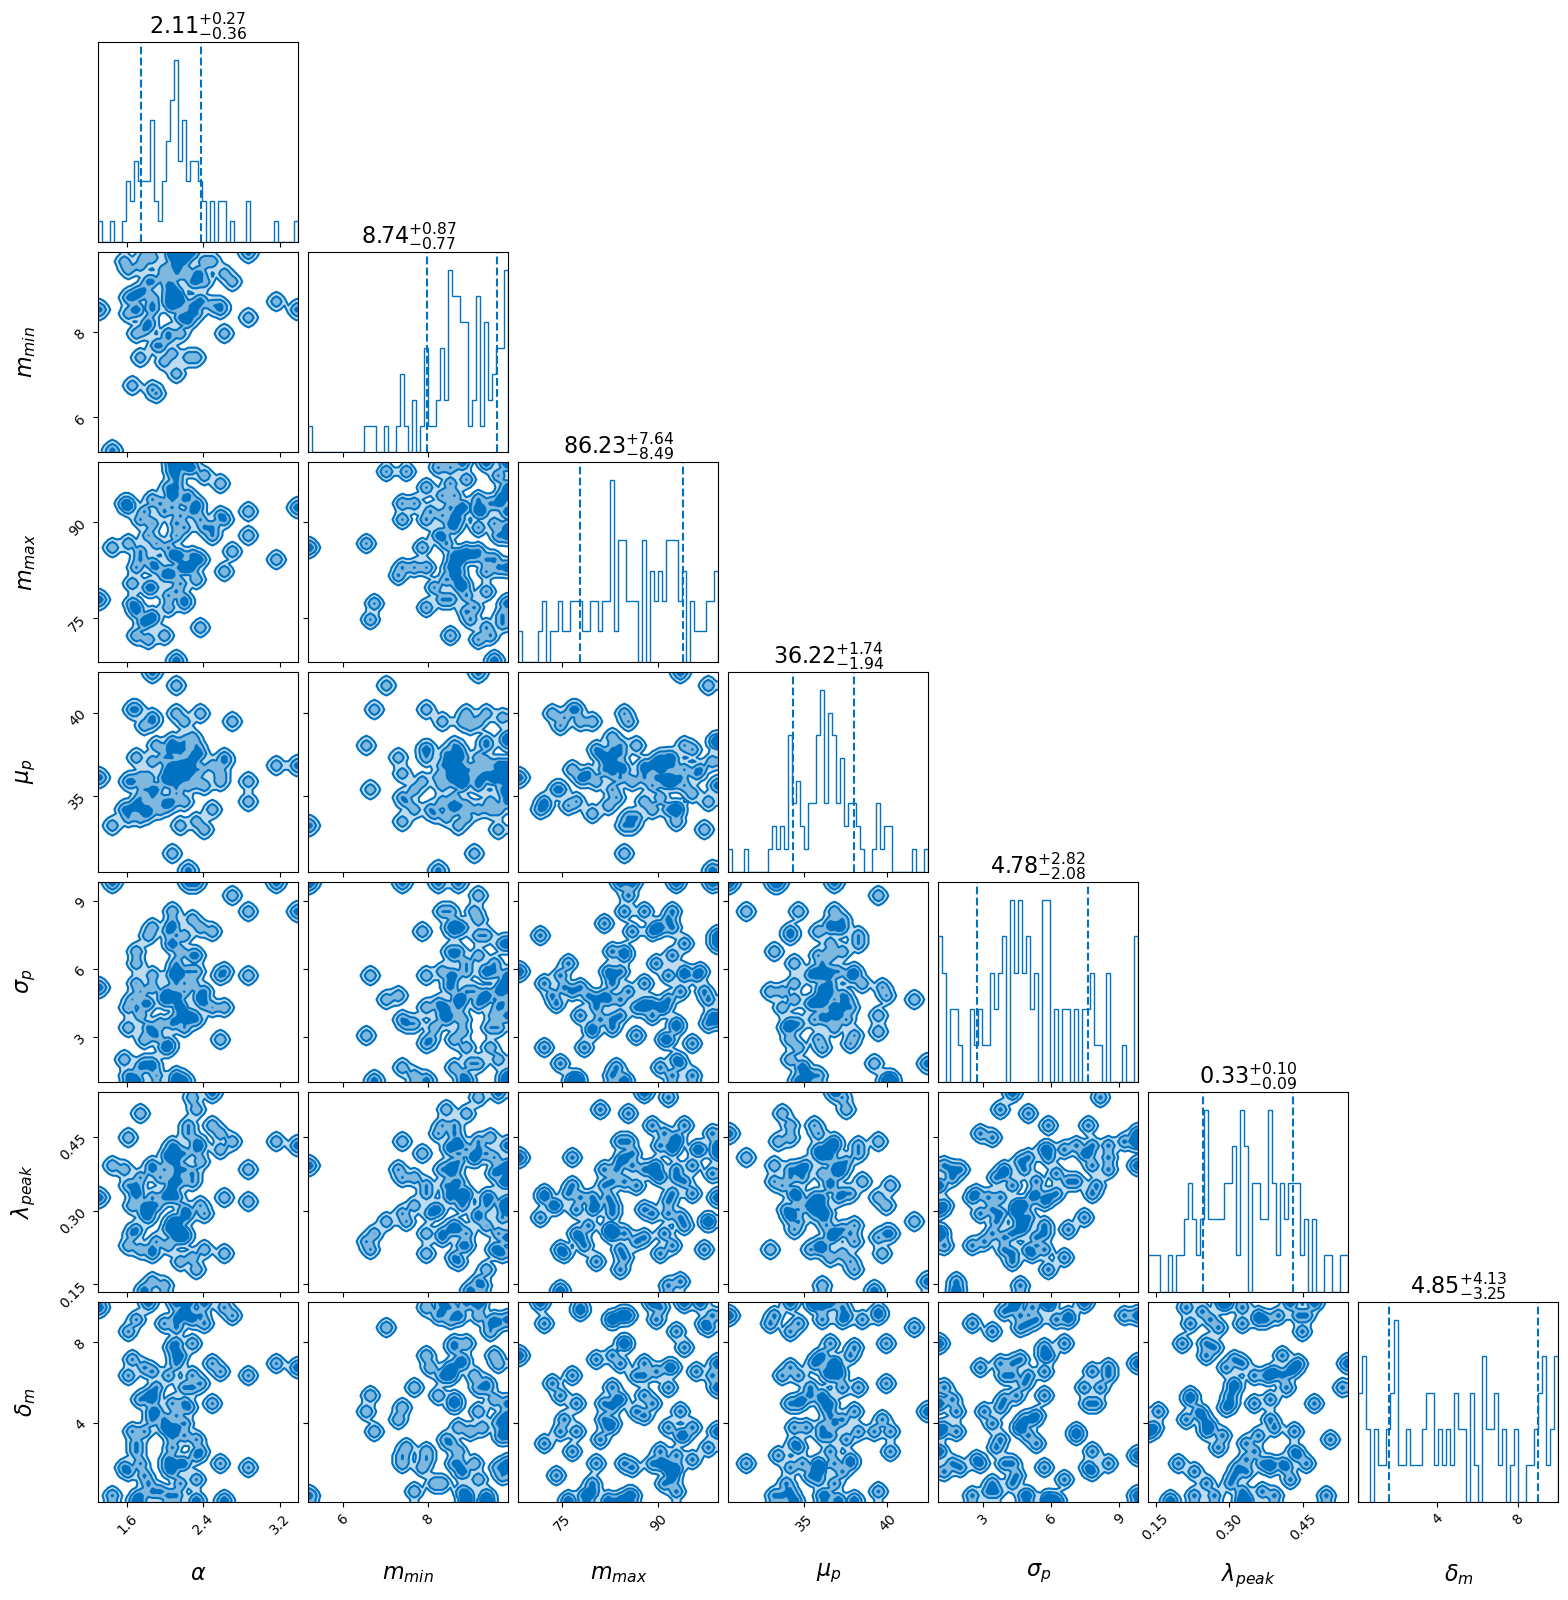

In [49]:
power_plus_peak_result.plot_corner(savefig=False)

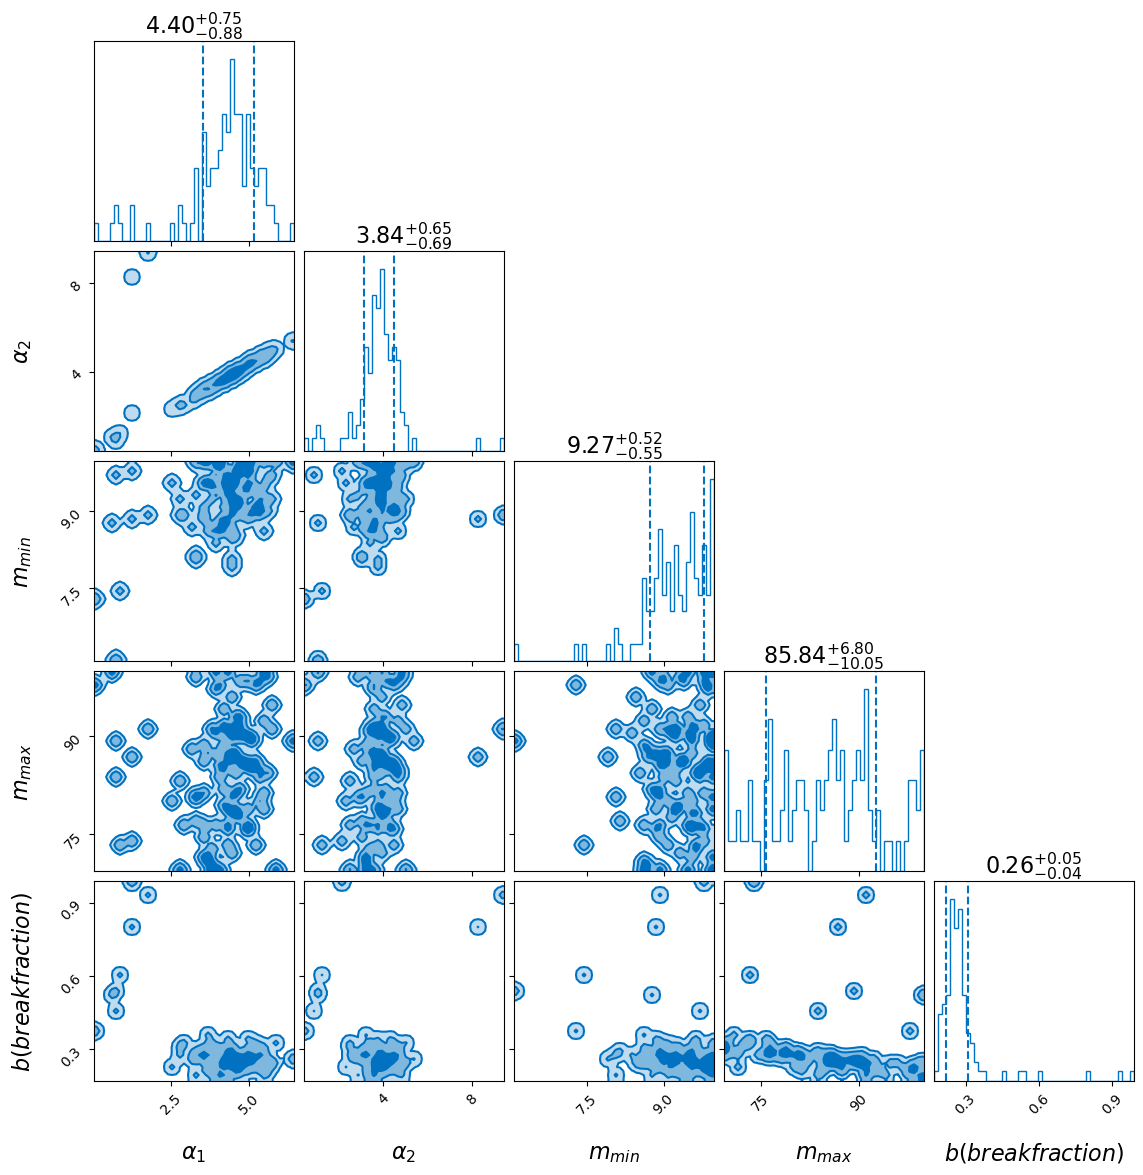

In [50]:
broken_power_law_result.plot_corner(savefig=False)

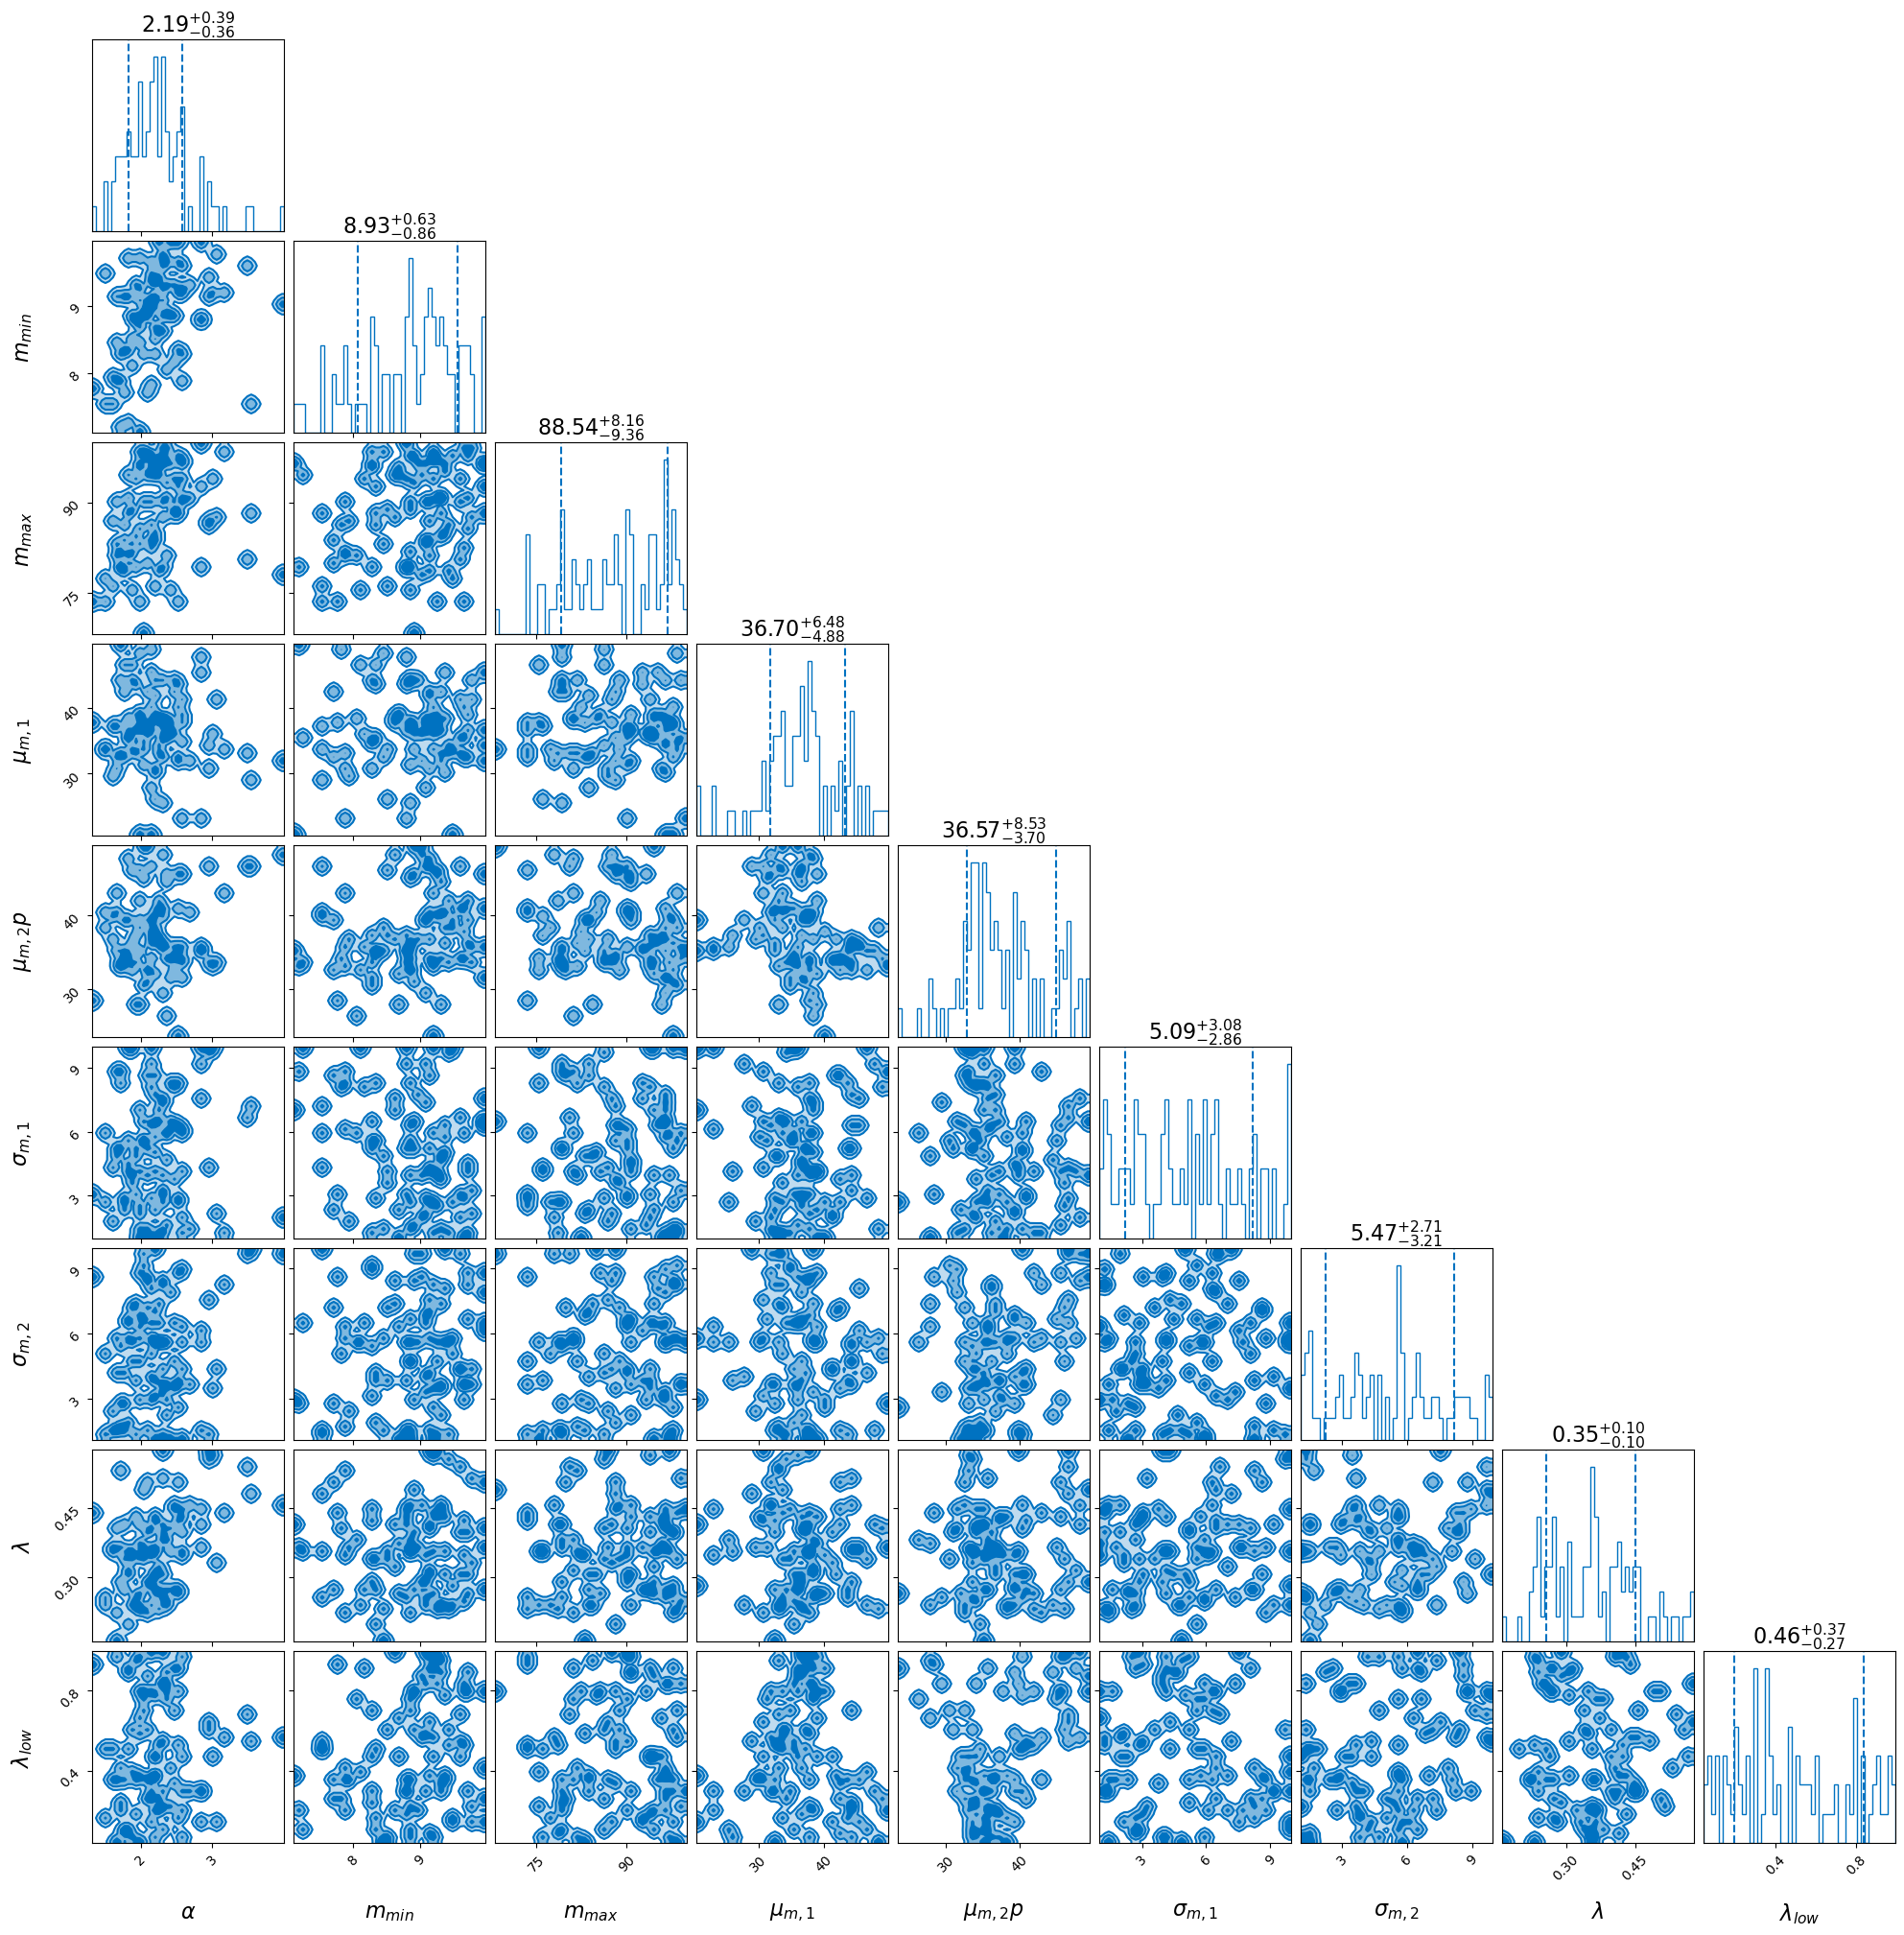

In [51]:
multi_peak_result.plot_corner(savefig=False)

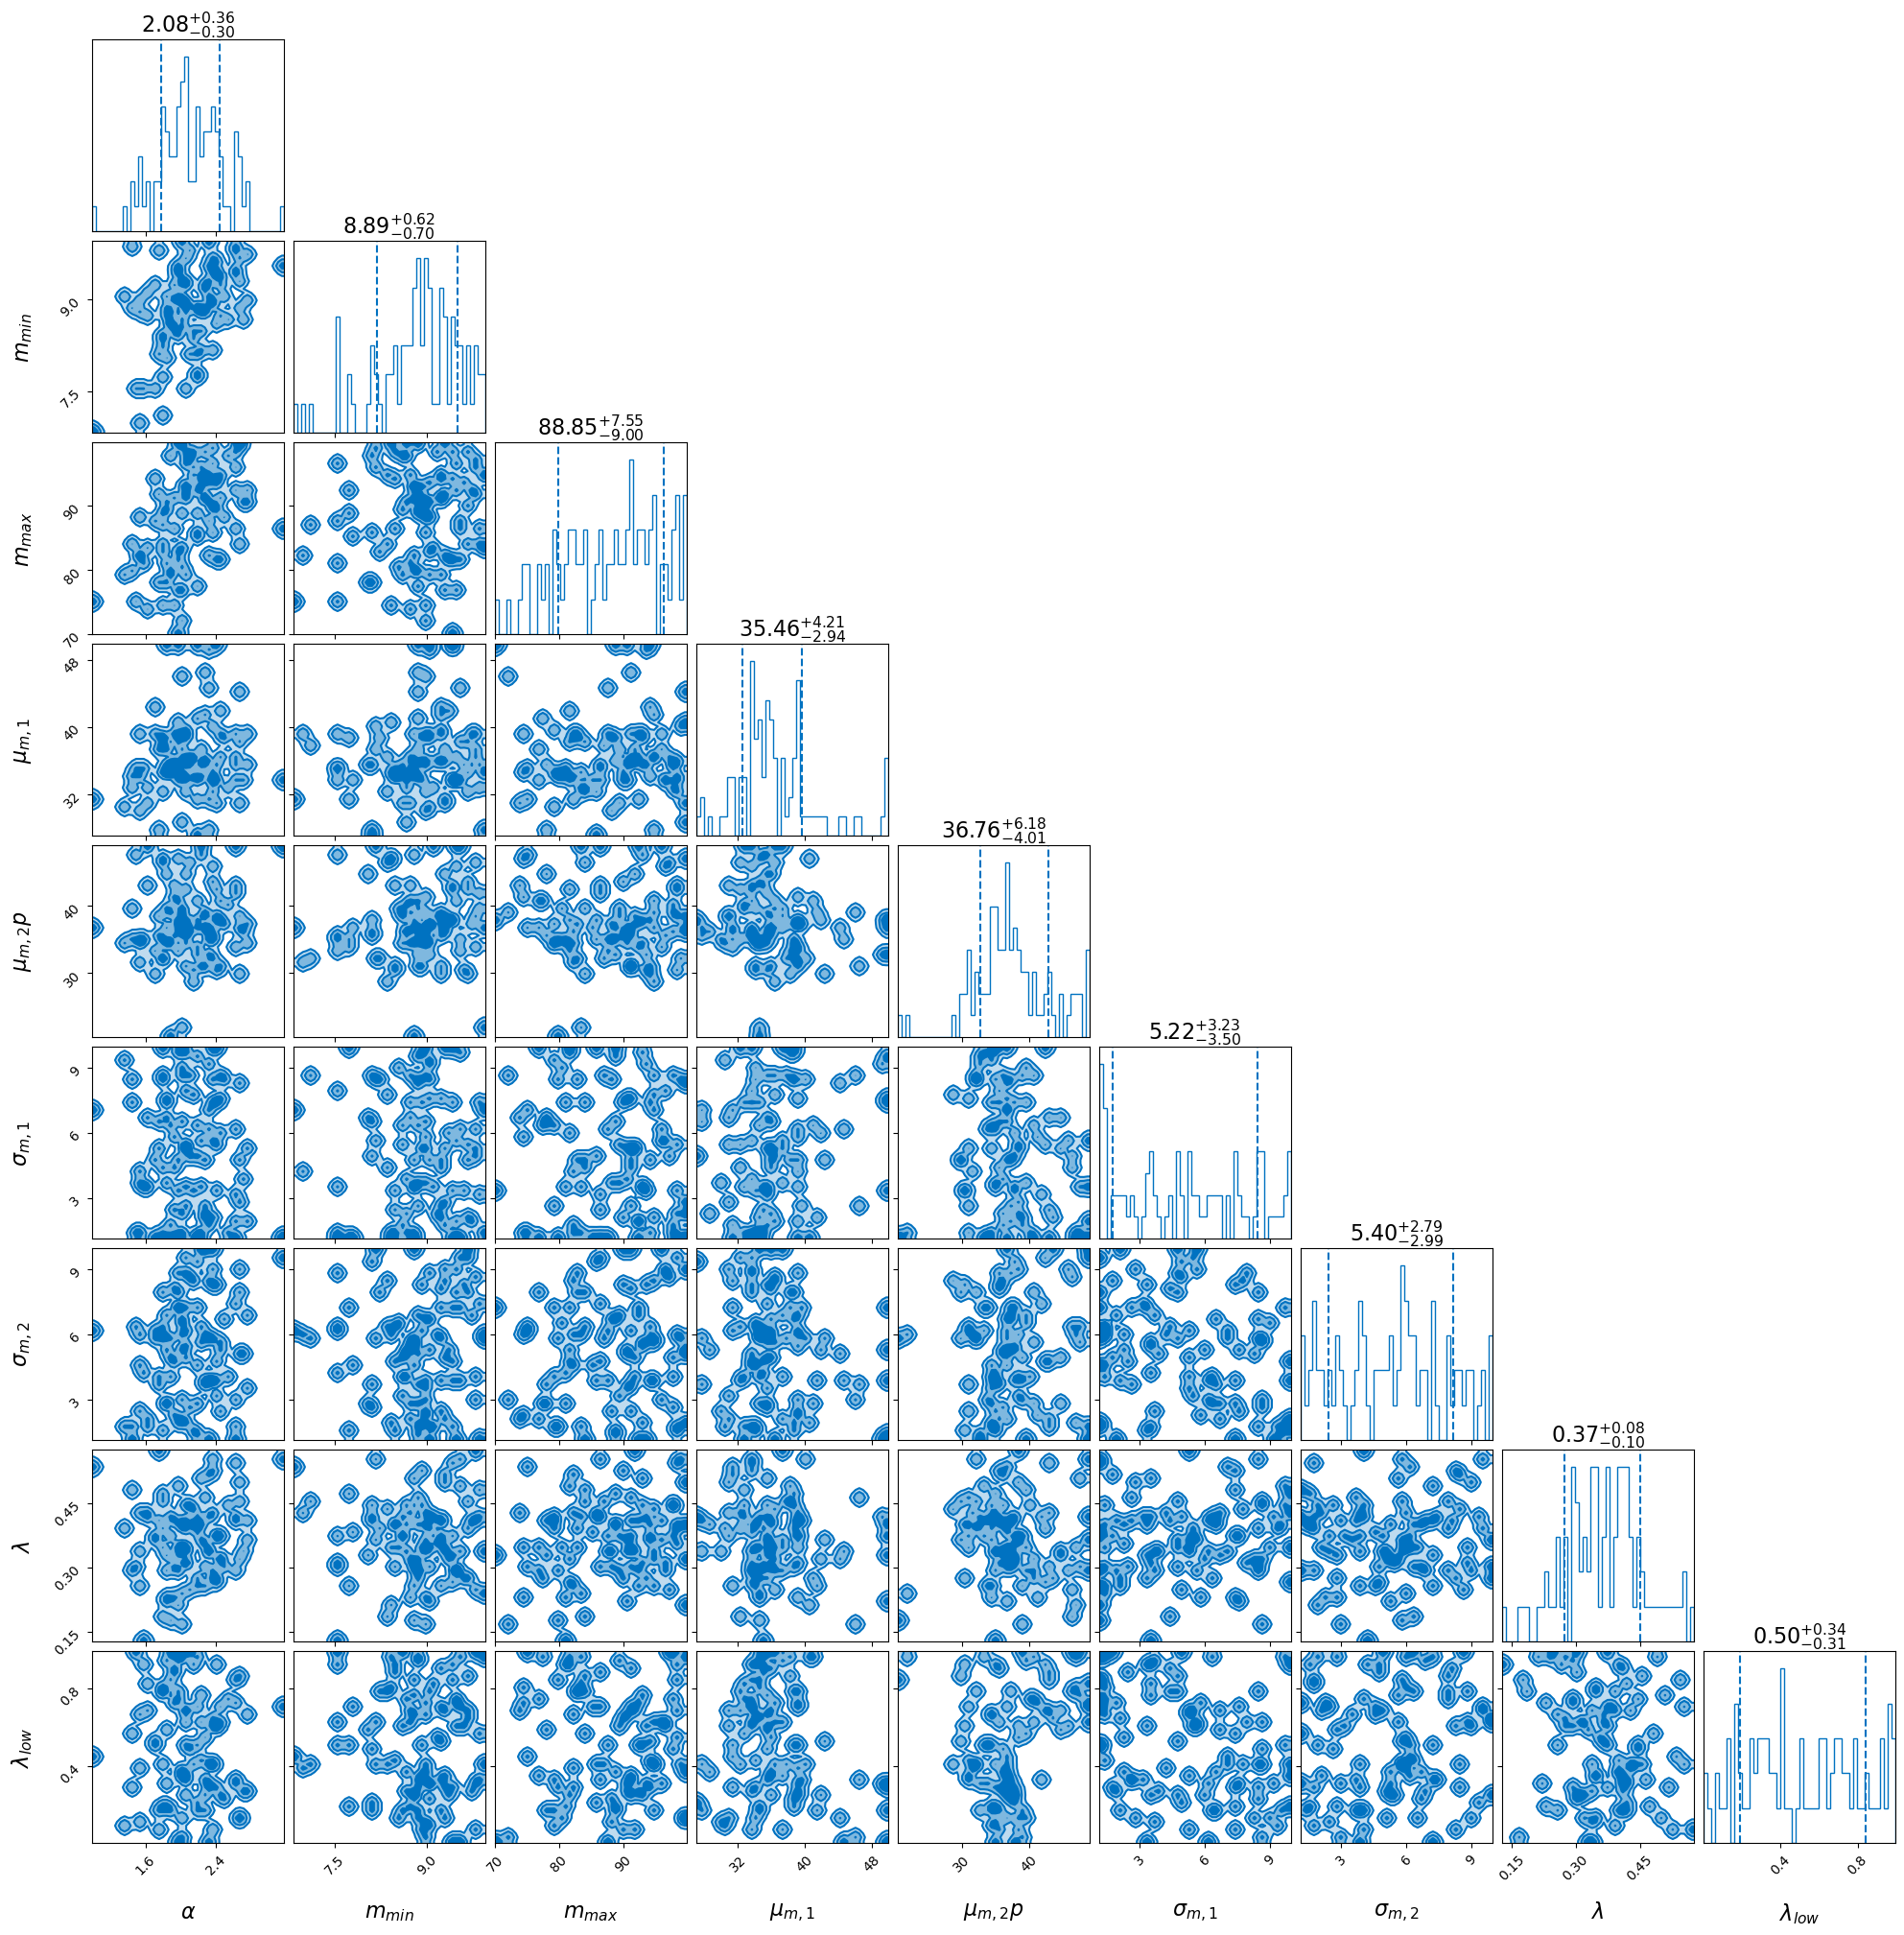

In [52]:
gwpop_multi_peak_result.plot_corner(savefig=False)

### Mass Distributions

In [53]:
m_grid = np.linspace(5, 100, 300)

power_law_posterior = power_law_result.posterior
power_law_pdf = []

for idx, row in power_law_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    # Evaluate the PDF for this sample
    power_pdf_vals = power_law_mass_distribution(dataset={'mass_1':m_grid}, alpha=alpha_p, m_min=mmin_p, m_max=mmax_p)
    power_law_pdf.append(power_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
power_law_pdf_2D = np.array(power_law_pdf)

power_law_pdf_2D_mean = np.mean(power_law_pdf_2D, axis=0)
power_law_lower = np.percentile(power_law_pdf_2D, 5, axis=0)
power_law_upper = np.percentile(power_law_pdf_2D, 95, axis=0)

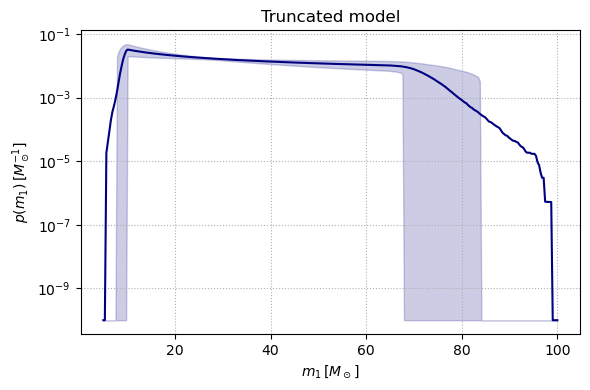

In [54]:
plt.figure(figsize=(6,4))

# Plot the "mean" as a solid line
plt.plot(m_grid, power_law_pdf_2D_mean, color='navy', label='Truncated model mean')

# Fill between the lower/upper percentiles
plt.fill_between(m_grid, power_law_lower, power_law_upper, color='navy', alpha=0.2, 
                 label='90% credible interval')

plt.yscale('log')
plt.xlabel(r'$m_1\,[M_\odot]$')
plt.ylabel(r'$p(m_1)\,[M_\odot^{-1}]$')
plt.title("Truncated model")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

In [55]:
m_grid = np.linspace(5, 100, 300)

gwpop_power_law_posterior = gwpop_power_law_result.posterior
gwpop_power_law_pdf = []

for idx, row in gwpop_power_law_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    # Evaluate the PDF for this sample
    gwpop_power_pdf_vals = gwpop_power_law_mass_distribution(dataset={'mass_1':m_grid}, alpha=alpha_p, m_min=mmin_p, m_max=mmax_p)
    gwpop_power_law_pdf.append(gwpop_power_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
gwpop_power_law_pdf_2D = np.array(gwpop_power_law_pdf)

gwpop_power_law_pdf_2D_mean = np.mean(gwpop_power_law_pdf_2D, axis=0)
gwpop_power_law_lower = np.percentile(gwpop_power_law_pdf_2D, 5, axis=0)
gwpop_power_law_upper = np.percentile(gwpop_power_law_pdf_2D, 95, axis=0)

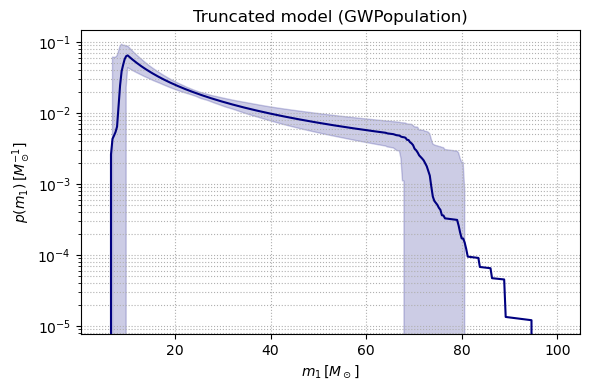

In [56]:
plt.figure(figsize=(6,4))

# Plot the "mean" as a solid line
plt.plot(m_grid, gwpop_power_law_pdf_2D_mean, color='navy', label='Truncated model mean')

# Fill between the lower/upper percentiles
plt.fill_between(m_grid, gwpop_power_law_lower, gwpop_power_law_upper, color='navy', alpha=0.2, 
                 label='90% credible interval')

plt.yscale('log')
plt.xlabel(r'$m_1\,[M_\odot]$')
plt.ylabel(r'$p(m_1)\,[M_\odot^{-1}]$')
plt.title("Truncated model (GWPopulation)")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

In [57]:
power_plus_peak_result.posterior

alpha     m_min      m_max        mpp     sigpp       lam     del_m  \
0   2.124318  7.014557  97.550526  41.722888  4.603833  0.280668  8.651321   
1   1.446547  5.190044  85.930211  33.263741  9.718105  0.395467  0.472441   
2   1.868513  9.191934  93.705438  42.467446  1.811019  0.152750  4.586357   
3   2.108132  9.552576  68.150026  35.991330  5.823347  0.405808  7.277343   
4   2.608144  7.988902  90.095426  37.201441  4.265685  0.216059  9.603720   
..       ...       ...        ...        ...       ...       ...       ...   
86  2.106346  8.850631  96.359375  36.620947  5.878501  0.421161  9.989481   
87  2.300623  8.558980  98.756521  37.109117  4.013701  0.374699  6.412550   
88  2.134161  8.855592  84.531008  39.944629  1.021219  0.256796  7.812589   
89  2.210951  9.821340  77.043350  34.678737  1.083956  0.299136  4.849592   
90  2.106711  8.788527  98.793401  35.621423  3.755766  0.329669  6.898478   

    log_likelihood  log_prior  
0      -260.556275 -16.195057  
1      -260.546572 -16.195057  
2      -260.485142 -16.195057  
3      -258.250762 -16.195057  
4      -257.855277 -16.195057  
..             ...        ...  
86     -253.206850 -16.195057  
87     -253.139097 -16.195057  
88     -252.978288 -16.195057  
89     -252.732836 -16.195057  
90     -252.667753 -16.195057  

[91 rows x 9 columns]

In [58]:
power_plus_peak_posterior = power_plus_peak_result.posterior
power_plus_peak_pdf = []

for idx, row in power_plus_peak_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    lam_p = row["lam"]
    sig_p = row['sigpp']
    mp_p = row['mpp']
    delm = row['del_m']
    # Evaluate the PDF for this sample
    power_plus_peak_pdf_vals = power_plus_peak_mass_distribution(dataset={'mass_1':m_grid},
                                                                    alpha=alpha_p,
                                                                    m_min=mmin_p, 
                                                                    m_max=mmax_p,
                                                                    lam=lam_p,
                                                                    sigpp=sig_p,
                                                                    mpp=mp_p,
                                                                    del_m=delm)
    power_plus_peak_pdf.append(power_plus_peak_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
power_plus_peak_pdf_2D = np.array(power_plus_peak_pdf)

power_plus_peak_pdf_2D_mean = np.mean(power_plus_peak_pdf_2D, axis=0)
power_plus_peak_lower = np.percentile(power_plus_peak_pdf_2D, 5, axis=0)
power_plus_peak_upper = np.percentile(power_plus_peak_pdf_2D, 95, axis=0)

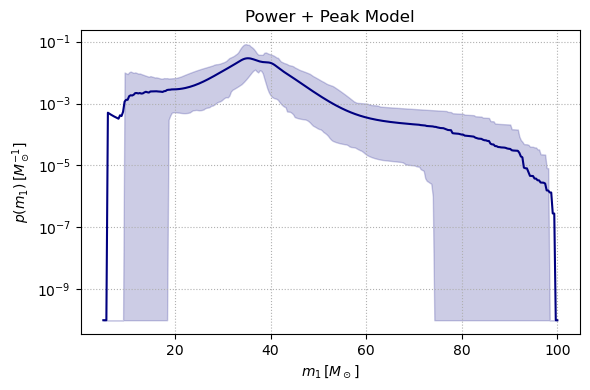

In [59]:
plt.figure(figsize=(6,4))

# Plot the "mean" as a solid line
plt.plot(m_grid, power_plus_peak_pdf_2D_mean, color='navy', label='Truncated model mean')

# Fill between the lower/upper percentiles
plt.fill_between(m_grid, power_plus_peak_lower, power_plus_peak_upper, color='navy', alpha=0.2, 
                 label='90% credible interval')

plt.yscale('log')
plt.xlabel(r'$m_1\,[M_\odot]$')
plt.ylabel(r'$p(m_1)\,[M_\odot^{-1}]$')
plt.title("Power + Peak Model")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

In [60]:
gwpop_power_plus_peak_posterior = gwpop_power_plus_peak_result.posterior
gwpop_power_plus_peak_pdf = []

for idx, row in gwpop_power_plus_peak_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    lam_p = row["lam"]
    sig_p = row['sigpp']
    mp_p = row['mpp']
    delm = row['del_m']
    # Evaluate the PDF for this sample
    gwpop_power_plus_peak_pdf_vals = gwpop_power_plus_peak_mass_distribution(dataset={'mass_1':m_grid},
                                                                    alpha=alpha_p,
                                                                    m_min=mmin_p, 
                                                                    m_max=mmax_p,
                                                                    lam=lam_p,
                                                                    sigpp=sig_p,
                                                                    mpp=mp_p
                                                                    )
    gwpop_power_plus_peak_pdf.append(gwpop_power_plus_peak_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
gwpop_power_plus_peak_pdf_2D = np.array(gwpop_power_plus_peak_pdf)

gwpop_power_plus_peak_pdf_2D_mean = np.mean(gwpop_power_plus_peak_pdf_2D, axis=0)
gwpop_power_plus_peak_lower = np.percentile(gwpop_power_plus_peak_pdf_2D, 5, axis=0)
gwpop_power_plus_peak_upper = np.percentile(gwpop_power_plus_peak_pdf_2D, 95, axis=0)

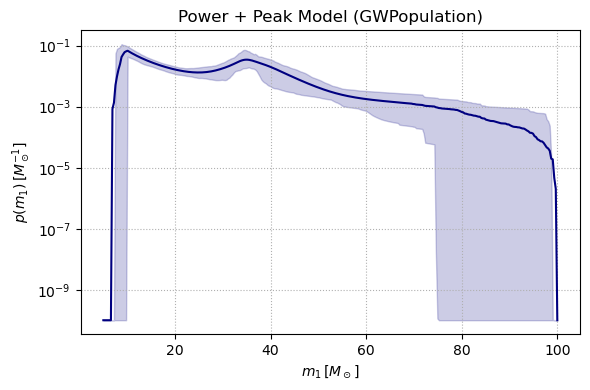

In [61]:
plt.figure(figsize=(6,4))

# Plot the "mean" as a solid line
plt.plot(m_grid, gwpop_power_plus_peak_pdf_2D_mean, color='navy', label='Truncated model mean')

# Fill between the lower/upper percentiles
plt.fill_between(m_grid, gwpop_power_plus_peak_lower, gwpop_power_plus_peak_upper, color='navy', alpha=0.2, 
                 label='90% credible interval')

plt.yscale('log')
plt.xlabel(r'$m_1\,[M_\odot]$')
plt.ylabel(r'$p(m_1)\,[M_\odot^{-1}]$')
plt.title("Power + Peak Model (GWPopulation)")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

In [62]:
power_plus_peak_posterior = power_plus_peak_result.posterior
power_plus_peak_pdf = []

for idx, row in power_plus_peak_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    lam_p = row["lam"]
    sig_p = row['sigpp']
    mp_p = row['mpp']
    delm = row['del_m']
    # Evaluate the PDF for this sample
    power_plus_peak_pdf_vals = power_plus_peak_mass_distribution(dataset={'mass_1':m_grid},
                                                                    alpha=alpha_p,
                                                                    m_min=mmin_p, 
                                                                    m_max=mmax_p,
                                                                    lam=lam_p,
                                                                    sigpp=sig_p,
                                                                    mpp=mp_p,
                                                                    del_m=delm)
    power_plus_peak_pdf.append(power_plus_peak_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
power_plus_peak_pdf_2D = np.array(power_plus_peak_pdf)

power_plus_peak_pdf_2D_mean = np.mean(power_plus_peak_pdf_2D, axis=0)
power_plus_peak_lower = np.percentile(power_plus_peak_pdf_2D, 5, axis=0)
power_plus_peak_upper = np.percentile(power_plus_peak_pdf_2D, 95, axis=0)

In [63]:
power_plus_peak_posterior = power_plus_peak_result.posterior
power_plus_peak_pdf = []

for idx, row in power_plus_peak_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    lam_p = row["lam"]
    sig_p = row['sigpp']
    mp_p = row['mpp']
    delm = row['del_m']
    # Evaluate the PDF for this sample
    power_plus_peak_pdf_vals = power_plus_peak_mass_distribution(dataset={'mass_1':m_grid},
                                                                    alpha=alpha_p,
                                                                    m_min=mmin_p, 
                                                                    m_max=mmax_p,
                                                                    lam=lam_p,
                                                                    sigpp=sig_p,
                                                                    mpp=mp_p,
                                                                    del_m=delm)
    power_plus_peak_pdf.append(power_plus_peak_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
power_plus_peak_pdf_2D = np.array(power_plus_peak_pdf)

power_plus_peak_pdf_2D_mean = np.mean(power_plus_peak_pdf_2D, axis=0)
power_plus_peak_lower = np.percentile(power_plus_peak_pdf_2D, 5, axis=0)
power_plus_peak_upper = np.percentile(power_plus_peak_pdf_2D, 95, axis=0)

In [64]:
power_plus_peak_posterior = power_plus_peak_result.posterior
power_plus_peak_pdf = []

for idx, row in power_plus_peak_posterior.iterrows():
    alpha_p = row["alpha"]
    mmin_p  = row["m_min"]
    mmax_p  = row["m_max"]
    lam_p = row["lam"]
    sig_p = row['sigpp']
    mp_p = row['mpp']
    delm = row['del_m']
    # Evaluate the PDF for this sample
    power_plus_peak_pdf_vals = power_plus_peak_mass_distribution(dataset={'mass_1':m_grid},
                                                                    alpha=alpha_p,
                                                                    m_min=mmin_p, 
                                                                    m_max=mmax_p,
                                                                    lam=lam_p,
                                                                    sigpp=sig_p,
                                                                    mpp=mp_p,
                                                                    del_m=delm)
    power_plus_peak_pdf.append(power_plus_peak_pdf_vals)

# Convert to a 2D array => shape (n_samples, len(m_grid))
power_plus_peak_pdf_2D = np.array(power_plus_peak_pdf)

power_plus_peak_pdf_2D_mean = np.mean(power_plus_peak_pdf_2D, axis=0)
power_plus_peak_lower = np.percentile(power_plus_peak_pdf_2D, 5, axis=0)
power_plus_peak_upper = np.percentile(power_plus_peak_pdf_2D, 95, axis=0)

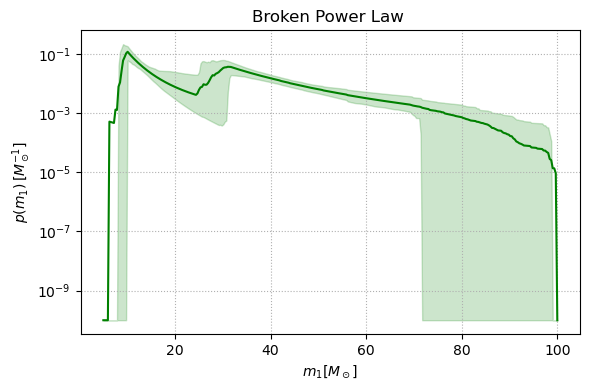

In [65]:
my_broken_posterior = broken_power_law_result.posterior
my_broken_pdf_list = []

# Loop over posterior samples
for idx, row in my_broken_posterior.iterrows():
    alpha1_p = row["alpha_1"]
    alpha2_p = row["alpha_2"]
    mmin_p   = row["m_min"]
    mmax_p   = row["m_max"]
    bf_p     = row["break_fraction"]
    
    # Evaluate your custom broken power law
    pdf_vals = broken_power_law_mass_distribution(
        dataset={'mass_1': m_grid},
        alpha_1=alpha1_p,
        alpha_2=alpha2_p,
        m_min=mmin_p,
        m_max=mmax_p,
        break_fraction=bf_p,
    )
    my_broken_pdf_list.append(pdf_vals)

# Convert to 2D array => shape (n_samples, len(m_grid))
my_broken_pdf_2D = np.array(my_broken_pdf_list)

# Mean / percentile curves
my_broken_mean = np.mean(my_broken_pdf_2D, axis=0)
my_broken_lower = np.percentile(my_broken_pdf_2D, 5, axis=0)
my_broken_upper = np.percentile(my_broken_pdf_2D, 95, axis=0)

# Plot
plt.figure(figsize=(6,4))
plt.plot(m_grid, my_broken_mean, color='green', 
         label='Broken Power Law (my) mean')
plt.fill_between(m_grid, my_broken_lower, my_broken_upper, 
                 color='green', alpha=0.2, label='90% credible interval')
plt.yscale('log')
plt.xlabel(r'$m_1 [M_\odot]$')
plt.ylabel(r'$p(m_1)\, [M_\odot^{-1}]$')
plt.title("Broken Power Law ")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

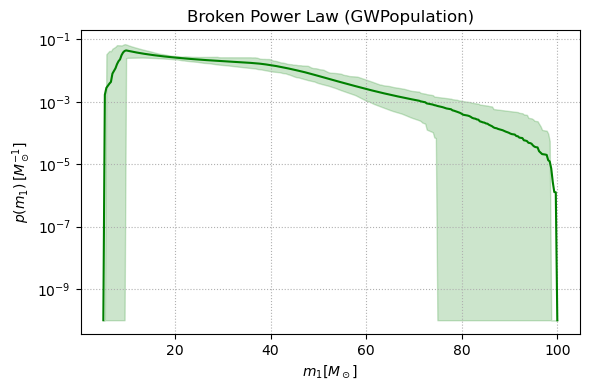

In [66]:
gwpop_broken_posterior = gwpop_broken_power_law_result.posterior
gwpop_broken_pdf_list = []

for idx, row in gwpop_broken_posterior.iterrows():
    alpha1_p = row["alpha_1"]
    alpha2_p = row["alpha_2"]
    mmin_p   = row["m_min"]
    mmax_p   = row["m_max"]
    bf_p     = row["break_fraction"]
    
    # Evaluate the gwpop wrapper
    pdf_vals = gwpop_broken_power_law_mass_distribution(
        dataset={'mass_1': m_grid},
        alpha_1=alpha1_p,
        alpha_2=alpha2_p,
        m_min=mmin_p,
        m_max=mmax_p,
        break_fraction=bf_p
    )
    gwpop_broken_pdf_list.append(pdf_vals)

gwpop_broken_pdf_2D = np.array(gwpop_broken_pdf_list)

gwpop_broken_mean  = np.mean(gwpop_broken_pdf_2D, axis=0)
gwpop_broken_lower = np.percentile(gwpop_broken_pdf_2D, 5, axis=0)
gwpop_broken_upper = np.percentile(gwpop_broken_pdf_2D, 95, axis=0)

plt.figure(figsize=(6,4))
plt.plot(m_grid, gwpop_broken_mean, color='green', 
         label='Broken PL (gwpop) mean')
plt.fill_between(m_grid, gwpop_broken_lower, gwpop_broken_upper, 
                 color='green', alpha=0.2, label='90% credible interval')
plt.yscale('log')
plt.xlabel(r'$m_1 [M_\odot]$')
plt.ylabel(r'$p(m_1)\, [M_\odot^{-1}]$')
plt.title("Broken Power Law (GWPopulation)")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

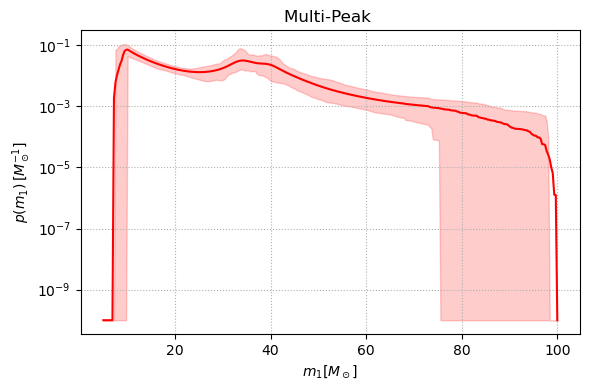

In [67]:
my_multi_posterior = multi_peak_result.posterior
my_multi_pdf_list = []

for idx, row in my_multi_posterior.iterrows():
    alpha_p   = row["alpha"]
    mmin_p    = row["m_min"]
    mmax_p    = row["m_max"]
    lam_p     = row["lam"]
    lam1_p    = row["lam_1"]
    mpp1_p    = row["mpp_1"]
    sig1_p    = row["sigpp_1"]
    mpp2_p    = row["mpp_2"]
    sig2_p    = row["sigpp_2"]
    
    pdf_vals = multi_peak_mass_distribution(
        dataset={'mass_1': m_grid},
        alpha=alpha_p,
        m_min=mmin_p,
        m_max=mmax_p,
        lam=lam_p,
        lam_1=lam1_p,
        mpp_1=mpp1_p,
        sigpp_1=sig1_p,
        mpp_2=mpp2_p,
        sigpp_2=sig2_p
    )
    my_multi_pdf_list.append(pdf_vals)

my_multi_pdf_2D = np.array(my_multi_pdf_list)
my_multi_mean  = np.mean(my_multi_pdf_2D, axis=0)
my_multi_lower = np.percentile(my_multi_pdf_2D, 5, axis=0)
my_multi_upper = np.percentile(my_multi_pdf_2D, 95, axis=0)

plt.figure(figsize=(6,4))
plt.plot(m_grid, my_multi_mean, color='red', 
         label='Multi-Peak (my) mean')
plt.fill_between(m_grid, my_multi_lower, my_multi_upper, 
                 color='red', alpha=0.2, label='90% credible interval')
plt.yscale('log')
plt.xlabel(r'$m_1 [M_\odot]$')
plt.ylabel(r'$p(m_1)\, [M_\odot^{-1}]$')
plt.title("Multi-Peak ")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

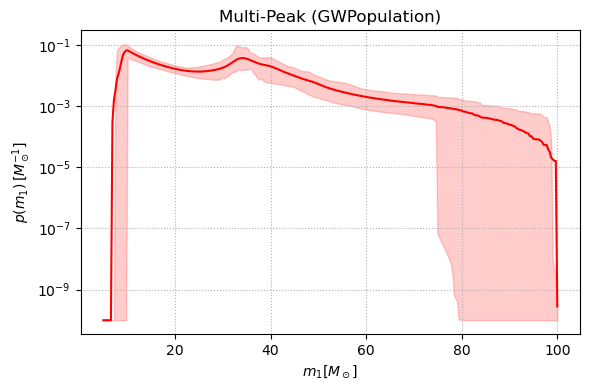

In [68]:
gwpop_multi_posterior = gwpop_multi_peak_result.posterior
gwpop_multi_pdf_list = []

for idx, row in gwpop_multi_posterior.iterrows():
    alpha_p   = row["alpha"]
    mmin_p    = row["m_min"]
    mmax_p    = row["m_max"]
    lam_p     = row["lam"]
    lam1_p    = row["lam_1"]
    mpp1_p    = row["mpp_1"]
    sig1_p    = row["sigpp_1"]
    mpp2_p    = row["mpp_2"]
    sig2_p    = row["sigpp_2"]
    
    pdf_vals = gwpop_multi_peak_mass_distribution(
        dataset={'mass_1': m_grid},
        alpha=alpha_p,
        m_min=mmin_p,
        m_max=mmax_p,
        lam=lam_p,
        lam_1=lam1_p,
        mpp_1=mpp1_p,
        sigpp_1=sig1_p,
        mpp_2=mpp2_p,
        sigpp_2=sig2_p
    )
    gwpop_multi_pdf_list.append(pdf_vals)

gwpop_multi_pdf_2D = np.array(gwpop_multi_pdf_list)
gwpop_multi_mean  = np.mean(gwpop_multi_pdf_2D, axis=0)
gwpop_multi_lower = np.percentile(gwpop_multi_pdf_2D, 5, axis=0)
gwpop_multi_upper = np.percentile(gwpop_multi_pdf_2D, 95, axis=0)

plt.figure(figsize=(6,4))
plt.plot(m_grid, gwpop_multi_mean, color='red', 
         label='Multi-Peak (gwpop) mean')
plt.fill_between(m_grid, gwpop_multi_lower, gwpop_multi_upper, 
                 color='red', alpha=0.2, label='90% credible interval')
plt.yscale('log')
plt.xlabel(r'$m_1 [M_\odot]$')
plt.ylabel(r'$p(m_1)\, [M_\odot^{-1}]$')
plt.title("Multi-Peak (GWPopulation)")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

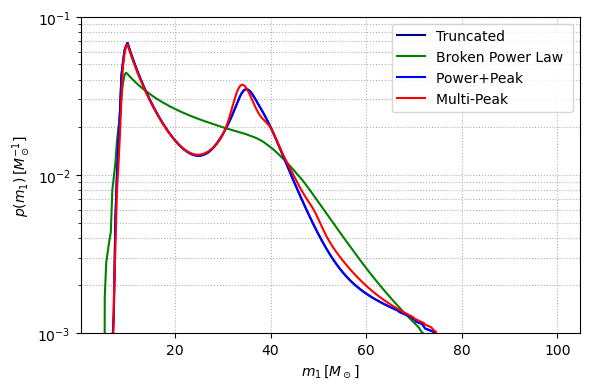

In [71]:
m1_grid = np.linspace(5, 85, 300)


plt.figure(figsize=(6, 4))

# 1) Truncated
plt.plot(
    m1_grid, gwpop_power_plus_peak_pdf_2D_mean,
    color='navy', label='Truncated '
)

# 2) Broken Power Law
plt.plot(
    m1_grid, gwpop_broken_mean,
    color='green', label='Broken Power Law '
)


# 3) Power + Peak
plt.plot(
    m1_grid, gwpop_power_plus_peak_pdf_2D_mean,
    color='blue', label='Power+Peak '
)


# 4) Multi-Peak
plt.plot(
    m1_grid, gwpop_multi_mean,
    color='red', label='Multi-Peak '
)


# LOG SCALE (optional)
plt.yscale('log')

plt.xlabel(r'$m_1 \,[M_\odot]$')
plt.ylabel(r'$p(m_1)\,[M_\odot^{-1}]$')  # or dR/dm_1 if you have a rate
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()